In [233]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

all_files = glob.glob("roll_data/*-strikes.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [156]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]  # * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]  # * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]  # * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2 / freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

In [32]:
# dfc = dfc[dfc["pitcher_multiplier"] == 1]
# dfc = dfc[dfc["batter_multiplier"] == 1]

In [247]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass  # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
        # mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        # mul += min(0.05, 0.05 * (row["day"] / 99))
        pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    return mul


df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

,offset,home_score,away_score,top_of_inning,inning,pitcher_mul,batter_mul,baserunner_count,event_type,roll,...,pitcher_ruthlessness,batter_musclitude,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,play_count
3989,-0.012996,2.0,0.0,False,1,1.0,1.0,[],Ball,0.863390,...,1.204338,1.682018,Valentine Games,Coolname Galvanic,NaN,NaN,SUN_KISSED,NaN,32,64
25777,-0.002915,0.0,0.0,True,1,1.0,1.0,[],Ball,0.877780,...,1.356621,0.885695,Ki-hir- Guerr-,PolkaDot Patterson,ALTERNATE;SCATTERED,SQUIDDISH;SWIM_BLADDER,LOVE,HIGH_PRESSURE,49,39
26878,-0.007623,2.0,2.0,True,11,1.0,1.0,[],Ball,0.917117,...,1.356621,1.326139,Knight Triumphant,PolkaDot Patterson,SIPHON;PERK,SQUIDDISH;SWIM_BLADDER,LOVE,HIGH_PRESSURE,49,346


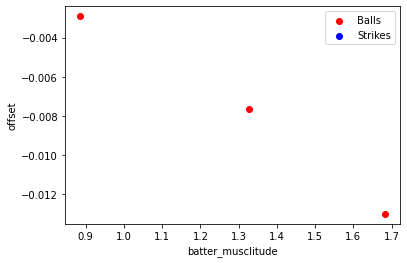

In [248]:
dfc = df
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0

fwd = dfc["ballpark_forwardness"]
ruth_scaled = dfc["pitcher_ruthlessness"] * dfc["pitcher_mul"]
ruth_vibed = ruth_scaled + 0.2 * (ruth_scaled * dfc["pitcher_vibes"])
musc = dfc["batter_musclitude"] * dfc["batter_mul"]
musc_vibed = musc  # * (1 - 0.005*dfc["batter_vibes"])
thres = 0.2 + 0.3 * ruth_vibed + 0.2 * fwd + 0.1 * musc_vibed

dfc["threshold"] = thres
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "batter_musclitude"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
table[
    [
        "offset",
        "home_score",
        "away_score",
        "top_of_inning",
        "inning",
        "pitcher_mul",
        "batter_mul",
        "baserunner_count",
        "event_type",
        "roll",
        "threshold",
        "batter_vibes",
        "pitcher_vibes",
        "pitcher_ruthlessness",
        "batter_musclitude",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "play_count",
    ]
]

In [244]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

dfc["ruth_scaled"] = dfc["pitcher_ruthlessness"] * dfc["pitcher_mul"]
dfc["musc_scaled"] = dfc["batter_musclitude"] * dfc["batter_mul"]
dfc["ruth_vibes"] = dfc["ruth_scaled"] * dfc["pitcher_vibes"]

X = dfc[["roll", "ruth_scaled", "ballpark_forwardness", "musc_scaled", "ruth_vibes"]]
y = dfc["passed"]

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(C=1000, dual=True, max_iter=100000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))

[[21234     4]
 [   13 17851]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21238
        True       1.00      1.00      1.00     17864

    accuracy                           1.00     39102
   macro avg       1.00      1.00      1.00     39102
weighted avg       1.00      1.00      1.00     39102



c:\Users\Astrid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [245]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.3012565605258089, 'ruth_scaled'),
 (-0.19885909763129214, 'ballpark_forwardness'),
 (-0.09891019543991302, 'musc_scaled'),
 (-0.05949726642273701, 'ruth_vibes')]

In [246]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.19978036])